In [ ]:
# Video Source: https://www.pexels.com/video/a-butterfly-on-a-flower-9672686/
# Written By M.Bdaqli , April 28, 2025

In [16]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import cv2
import numpy as np
import os
from datetime import datetime

class ButterflyWingMotionMaskedTracker:
    def __init__(self, video_path):
        now = datetime.now().strftime("%m%d_%H%M")
        self.base_drive_folder = '/content/drive/MyDrive/ButterflyDenseTrackingResults'
        self.output_dir = os.path.join(self.base_drive_folder, f'results_{now}')
        os.makedirs(self.output_dir, exist_ok=True)

        self.video_path = video_path
        print(f"Initialized for: {os.path.basename(video_path)}")
        print(f"Saving to: {self.output_dir}")

    def track(self):
        cap = cv2.VideoCapture(self.video_path)
        if not cap.isOpened():
            print("Couldn't open video")
            return False

        fps = cap.get(cv2.CAP_PROP_FPS)
        start_frame = int(14 * fps)
        end_frame = int(20 * fps)
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        ret, frame1 = cap.read()
        if not ret:
            print("Error: Cannot read first frame")
            return False

        prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        hsv = np.zeros_like(frame1)
        hsv[..., 1] = 255

        height, width = prvs.shape

        # Define the butterfly area mask
        mask = np.zeros_like(prvs, dtype=np.uint8)
        roi_x1, roi_y1 = int(width * 0.35), int(height * 0.25)
        roi_x2, roi_y2 = int(width * 0.75), int(height * 0.65)
        mask[roi_y1:roi_y2, roi_x1:roi_x2] = 255  # White rectangle around butterfly area

        frame_idx = start_frame
        motion_frames = []

        while frame_idx <= end_frame:
            ret, frame2 = cap.read()
            if not ret:
                break

            next_frame = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

            # Dense Optical Flow (Farneback)
            flow = cv2.calcOpticalFlowFarneback(
                prvs, next_frame, None,
                0.5, 3, 15, 3, 5, 1.2, 0
            )

            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

            # Apply the butterfly area mask
            mag = cv2.bitwise_and(mag, mag, mask=mask)
            ang = cv2.bitwise_and(ang, ang, mask=mask)

            # Threshold to keep strong motions only
            motion_mask = (mag > 2.0)

            hsv[..., 0] = ang * 180 / np.pi / 2
            hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

            # Zero out slow-moving and out-of-ROI areas
            hsv[..., 2][~motion_mask] = 0

            bgr_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

            # Save motion frames
            motion_frames.append(bgr_flow)

            prvs = next_frame.copy()
            frame_idx += 1

        cap.release()

        # Save output motion video
        if motion_frames:
            video_out = cv2.VideoWriter(
                os.path.join(self.output_dir, 'butterfly_wing_motion_masked.mp4'),
                cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height)
            )
            for frame in motion_frames:
                video_out.write(frame)
            video_out.release()

        print(f" Tracking complete - {len(motion_frames)} frames processed")
        print(f"Results saved at: {self.output_dir}")
        return True

    def analyze(self):
        return self.track()

def analyze_butterfly(video_path):
    tracker = ButterflyWingMotionMaskedTracker(video_path)
    tracker.analyze()

# RUN
analyze_butterfly('/content/drive/MyDrive/Butterfly Motion Track/Butterflywing.mp4')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Initialized for: Butterflywing.mp4
Saving to: /content/drive/MyDrive/ButterflyDenseTrackingResults/results_0428_0922
 Tracking complete - 145 frames processed
Results saved at: /content/drive/MyDrive/ButterflyDenseTrackingResults/results_0428_0922


##RESULTS:

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq -

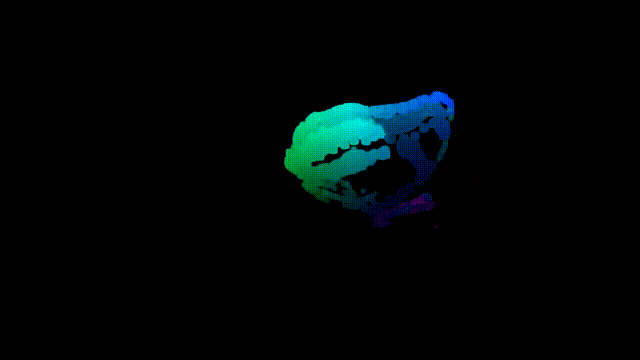

In [20]:
!apt install ffmpeg
from IPython.display import Image
!ffmpeg -i '/content/drive/MyDrive/ButterflyDenseTrackingResults/results_0428_0922/butterfly_wing_motion_masked.mp4' \
-vf "fps=10,scale=640:-1:flags=lanczos" \
'/content/drive/MyDrive/ButterflyDenseTrackingResults/results_0428_0922/butterfly_motion.gif'
Image(filename='/content/drive/MyDrive/ButterflyDenseTrackingResults/results_0428_0922/butterfly_motion.gif')
